# Testing implementation
As the present implementation includes an own simulator, circuit class and sampler, we should verify that these code components all work properly by comparing to earlier results done with the help of the `PECOS` library: https://github.com/dpwinter/PECOS_WS_solutions/blob/main/subset_sampling.ipynb

In [1]:
import sampler
from circuit import Circuit
import numpy as np
import matplotlib.pyplot as plt
import calc

First, create the GHZ preparation circuit that was used in all cells in the reference.

In [2]:
ghz = Circuit()
ghz.append(('h', 0))
ghz.append(('cnot', (0,1)))
ghz.append(('cnot', (1,2)))
ghz.append(('cnot', (2,3)))
ghz.append(('cnot', (3,4)))
ghz.append(('cnot', (0,4)))
ghz.append(('measure', 4))
print(ghz)

0: ('h', 0)
1: ('cnot', (0, 1))
2: ('cnot', (1, 2))
3: ('cnot', (2, 3))
4: ('cnot', (3, 4))
5: ('cnot', (0, 4))
6: ('measure', 4)


Now, run a simple direct MC run with the same parameters.

CPU times: user 17.9 s, sys: 0 ns, total: 17.9 s
Wall time: 17.9 s


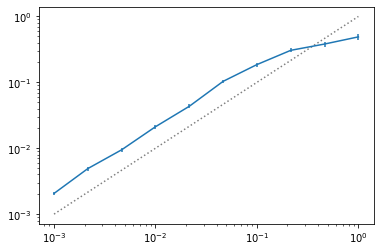

In [13]:
%%time

p_phys = np.logspace(-3,0,10)
n_samples = 100
sample_range = np.int_(n_samples / p_phys)
p_Ls = []
stds = []

for p,n in zip(p_phys,sample_range):  
    err_dict = {'p': p}
    ds = sampler.DirectSampler(ghz, err_dict)
    p_L, std = ds.run(n, var=calc.Wald_var)
    p_Ls.append(p_L)
    stds.append(std)

p_Ls = np.array(p_Ls).flatten()
stds = np.array(stds).flatten()
plt.xscale('log')
plt.yscale('log')
plt.errorbar(p_phys, p_Ls, yerr=stds)
plt.plot(p_phys, p_phys, 'k:', alpha=0.5)

This looks like we are getting the threshold at the same position, but the logical error rates below threshold are overall smaller than in the reference! Let's check how subset sampling performs.

[(0,), (1,), (2,)]
[(0,), (1,)]


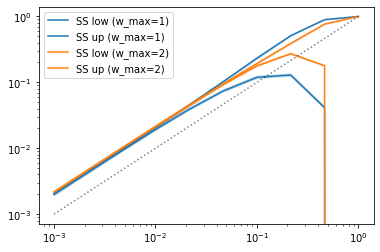

In [12]:
n_samples = 1000
p_phys = np.logspace(-3,0,10)

err_dict = {'p': p_phys}
ss = sampler.SubsetSampler(ghz, err_dict)
print(ss._find_weights(p_max=[0.1], delta_max=[0.1])) # weight cutoff 2
print(ss._find_weights(p_max=[0.1], delta_max=[0.2])) # weight cutoff 1

for p_max,d_max,col,w_max in zip([0.1,0.1], [0.2,0.1], ['tab:blue', 'tab:orange'],[1,2]):
    p_L_up, p_L_low, std = ss.run(p_max=[p_max], delta_max=[d_max], n_samples=n_samples, var=calc.Wald_var, SS_sel_fn=calc.balanced_SS_selector)
    plt.plot(p_phys, p_L_low, label="SS low (w_max=%s)"%w_max, c=col)
    plt.fill_between(p_phys, p_L_low-std, p_L_low+std, alpha=0.2, color=col)
    plt.plot(p_phys, p_L_up, label="SS up (w_max=%s)"%w_max, c=col)
    plt.fill_between(p_phys, p_L_up-std, p_L_up+std, alpha=0.2, color=col)
    plt.xscale('log')
    plt.yscale('log')
plt.plot(p_phys, p_phys, 'k:', alpha=0.5)
plt.legend()

Here, we again see a difference in results to the reference done in PECOS. We also see a mismatch in the interval p_phys=\[$10^{-1}$,$10^0$\] Let's plot them together.

CPU times: user 18.4 s, sys: 3.77 ms, total: 18.4 s
Wall time: 18.4 s


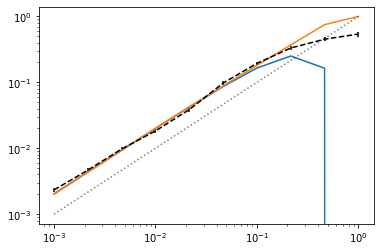

In [6]:
%%time

p_phys = np.logspace(-3,0,10)
n_samples = 100
sample_range = np.int_(n_samples / p_phys)
p_Ls = []
stds = []

for p,n in zip(p_phys,sample_range):  
    err_dict = {'p': p}
    ds = sampler.DirectSampler(ghz, err_dict)
    p_L, std = ds.run(n, var=calc.Wald_var)
    p_Ls.append(p_L)
    stds.append(std)
p_Ls = np.array(p_Ls).flatten()
stds = np.array(stds).flatten()
    
err_dict = {'p': p_phys}
ss = sampler.SubsetSampler(ghz, err_dict)
p_L_up, p_L_low, std = ss.run(p_max=[0.1], delta_max=[0.1], n_samples=1000, var=calc.Wald_var, SS_sel_fn=calc.balanced_SS_selector)

plt.errorbar(p_phys, p_Ls, fmt='--', c="black", yerr=stds)
plt.plot(p_phys, p_L_low)
plt.fill_between(p_phys, p_L_low-std, p_L_low+std, alpha=0.2)
plt.plot(p_phys, p_L_up)
plt.fill_between(p_phys, p_L_up-std, p_L_up+std, alpha=0.2)
plt.plot(p_phys, p_phys, 'k:', alpha=0.5)

plt.xscale('log')
plt.yscale('log')

However, since the direct and subset sampler agree very well, we see again that the error must be systematic in either PECOS's simulator or our own. Let's check out the other functions.

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


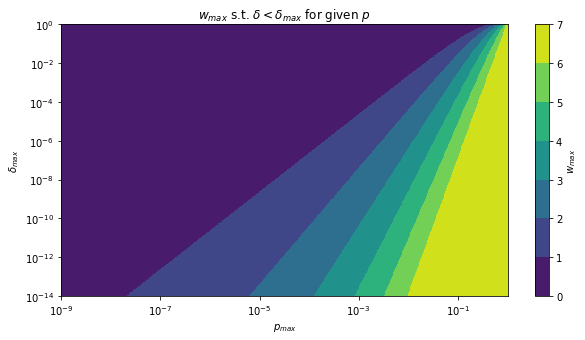

In [7]:
%time

n_gates = len(ghz)

ps = np.logspace(-9, 0, 500) # physical error rates
ds = np.logspace(-14, 0, 500)

Z = [[calc.weight_cutoff(p_max, d_max, n_gates) for p_max in ps] for d_max in ds]

plt.figure(figsize=(10,5))
plt.contourf(ps, ds, Z)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$p_{max}$')
plt.ylabel('$\delta_{max}$')
plt.colorbar(label="$w_{max}$")
plt.title('$w_{max}$ s.t. $\delta<\delta_{max}$ for given $p$');
plt.show()

The $w_{max}$ selector is identical to the procedure used in the reference. Next, we check multi-parameter noise models.

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)]
CPU times: user 5.85 s, sys: 23.7 ms, total: 5.87 s
Wall time: 5.83 s


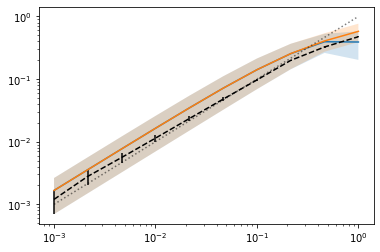

In [5]:
%%time

p1 = np.logspace(-3,0,10)
p2 = p1 * 0.5
err_dict = {'p1': p1, 'p2': p2}

ds = sampler.DirectSampler(ghz, err_dict)
p_L, std_ss = ds.run(n_samples=5000, var=calc.Wald_var)
    
ss = sampler.SubsetSampler(ghz, err_dict)
print(ss._find_weights(p_max=[0.5,0.5], delta_max=[0.1,0.5])) # weight cutoff
p_L_up, p_L_low, std = ss.run(p_max=[0.5,0.5], delta_max=[0.1,0.5], n_samples=20, var=calc.Wilson_var, SS_sel_fn=calc.balanced_SS_selector)

plt.errorbar(p1, p_L, fmt='--', c="black", yerr=std_ss)

plt.plot(p1, p_L_low)
plt.fill_between(p1, p_L_low-std, p_L_low+std, alpha=0.2)
plt.plot(p1, p_L_up)
plt.fill_between(p1, p_L_up-std, p_L_up+std, alpha=0.2)
plt.plot(p1, p1, 'k:', alpha=0.5)

plt.xscale('log')
plt.yscale('log')

Again, we see systematic underestimation in comparison to the reference. The only implementation difference which could cause such a systematic offset must be introduced by using a different simulator. Let's only change the simulator component to figure out what's going on with this systematic error by plotting the results using PECOS's `SparseSim` vs. using our own `StabSim`

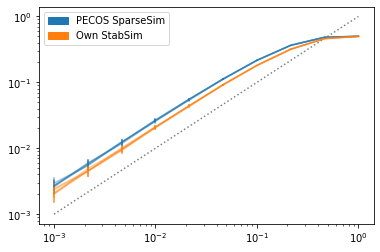

In [3]:
import pecos as pc
import simulator

ghz = Circuit([])
ghz.append(('H', 0))
ghz.append(('CNOT', (0,1)))
ghz.append(('CNOT', (1,2)))
ghz.append(('CNOT', (2,3)))
ghz.append(('CNOT', (3,4)))
ghz.append(('CNOT', (0,4)))
ghz.append(('measure Z', 4))

p_phys = np.logspace(-3,0,10)
err_dict = {'p': p_phys}
n_samples = 100000
n_reps = 5

### PECOS SIMULATOR

class DirectSamplerDiagnostic(sampler.DirectSampler):
    def run_circuit(self, sim, circuit, err_circuit):
        msmts = []
        for tick_idx, tick in enumerate(circuit):
            if type(tick) == list:
                for sub_tick in tick:
                    res = sim.run_gate(sub_tick[0], {sub_tick[1]})
                    if res: 
                        msmts.append((tick_idx,res))
            elif type(tick) == tuple:
                res = sim.run_gate(tick[0], {tick[1]})
                if res: 
                    msmts.append((tick_idx,res))
    
            if err_circuit:
                err_tick = err_circuit[tick_idx]
                if err_tick:
                    if type(err_tick) == list:
                        for sub_err_tick in err_tick:
                            sim.run_gate(sub_err_tick[0], {sub_err_tick[1]})
                    elif type(err_tick) == tuple:
                        sim.run_gate(err_tick[0], {err_tick[1]})
        return msmts
                        
    def _sample(self, err_gen=None, p_phys=None):
        sim = pc.simulators.SparseSim(self.n_qubits)
        err_circ = None if err_gen==None else err_gen.generate(self.partitions, p_phys)
        msmt = self.run_circuit(sim, self.circuit, err_circ)
        return msmt

for _ in range(n_reps):
    ds = DirectSamplerDiagnostic(ghz, err_dict)
    p_L, std = ds.run(n_samples=n_samples, var=calc.Wilson_var)
    plt.errorbar(p_phys, p_L, yerr=std, alpha=0.4, color='tab:blue')

### OWN SIMULATOR

ghz[-1] = ('measure', 4) # Need to redefine measure Z -> measure

class DirectSamplerDiagnostic2(sampler.DirectSampler):
    def run_circuit(self, sim, circuit, err_circuit):
        msmts = []
        for tick_idx, tick in enumerate(circuit):
            if type(tick) == list:
                for sub_tick in tick:
                    res = sim._apply_gate(sub_tick[0], sub_tick[1])
                    if res: 
                        msmts.append((tick_idx,res))
            elif type(tick) == tuple:
                res = sim._apply_gate(tick[0], tick[1])
                if res: 
                    msmts.append((tick_idx,res))
    
            if err_circuit:
                err_tick = err_circuit[tick_idx]
                if err_tick:
                    if type(err_tick) == list:
                        for sub_err_tick in err_tick:
                            sim._apply_gate(sub_err_tick[0], sub_err_tick[1])
                    elif type(err_tick) == tuple:
                        sim._apply_gate(err_tick[0], err_tick[1])
        return msmts
                        
    def _sample(self, err_gen=None, p_phys=None):
        sim = simulator.StabSim(self.n_qubits)
        err_circ = None if err_gen==None else err_gen.generate(self.partitions, p_phys)
        msmt = self.run_circuit(sim, self.circuit, err_circ)
        return msmt

for _ in range(n_reps):
    ds = DirectSamplerDiagnostic2(ghz, err_dict)
    p_L, std = ds.run(n_samples=n_samples, var=calc.Wilson_var)
    plt.errorbar(p_phys, p_L, yerr=std, alpha=0.4, color='tab:orange')
    
plt.xscale('log')
plt.yscale('log')
plt.plot(p_phys, p_phys, 'k:', alpha=0.5);

import matplotlib.patches as mpatches
l1 = mpatches.Patch(color='tab:blue', label='PECOS SparseSim')
l2 = mpatches.Patch(color='tab:orange', label='Own StabSim')
plt.legend(handles=[l1,l2]);

Here we can clearly see the difference between our own `StabSim` and PECOS's `SparseSim`. To see that `StabSim` always underestimates the error rate we repeated the sampling for n_rep times. Our implementation of StabSim is based on the implementation by Strilanc (https://github.com/Strilanc/python-chp-stabilizer-simulator), which is well-tested, close to the original paper and also used in other projects. In the PECOS package however are not direct logic tests of the simulator plus the Ciaran's implementation is more opaque and not so easy to understand. To tell from which fact the difference comes needs further inspection of both simulators. (Although I am pretty confident that `StabSim`'s performance is logically sound). 